In [7]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

df = pd.read_csv('housing-Copy1.csv')

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Checkout out the head.

In [5]:
num = [f for f in df.columns if df.dtypes[f] != 'object']
cat = [f for f in df.columns if df.dtypes[f] == 'object']
num.remove('median_house_value')
target = 'median_house_value' # Target. What we want to predict

# Preview
20640 rows with 10 variables. 8 numeric and 1 categorical. *median_house_value* is what we are trying to predict.
- Numeric: 'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'
- Categorical: 'ocean_proximity'
- Target: 'median_house_value'

In [6]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Target

In [9]:
df[target].hist(bins=100);
plt.savefig('target-housing.png')
plt.close();

![](target-housing.png)

In [10]:
df[target].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

The **median_house_value** is our target and there is a cap in the target at 500,000.

# Create A Test Set
When splitting data, check first if there are similar groups you want to stratify to get an even random split.

In [11]:
## Group median income according to 5 categories
df['income_cat'] = np.ceil(df[target] / 1.5)
df['income_cat'].where(df['income_cat'] < 5, 5.0, inplace=True)
num = num + ['income_cat']

In [12]:
## Using Startified Split
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['income_cat']):
    train = df.loc[train_index]
    test = df.loc[test_index]

In [13]:
df.income_cat.value_counts() / len(df)

5.0    1.0
Name: income_cat, dtype: float64

In [14]:
train.income_cat.value_counts() / len(train)

5.0    1.0
Name: income_cat, dtype: float64

In [15]:
test.income_cat.value_counts() / len(test)

5.0    1.0
Name: income_cat, dtype: float64

The _Test Set_ generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the _Test Set_ generated using purely random sampling is quite skewed.

You now have the Train dataset. From this point forward, all cleaning you do must be only done on Train. Test should not be touched because of it lead to overfitting when we come to evaluation.

# Explore Data
Start with checking correlations of numeric variables with the target data. Then make explore the data with many graphs but only show the top 3 graphs. Pairplot, scatterplot and a wildcard graph. Use only the train data in exploring.

## Correlations

In [16]:
train.corr()[target].sort_values(ascending=False).reset_index().style.bar()

,index,median_house_value
0,median_house_value,1.000000
1,median_income,0.689752
2,total_rooms,0.136167
3,housing_median_age,0.107050
4,households,0.068976
5,total_bedrooms,0.052690
6,population,-0.024618
7,longitude,-0.041830
8,latitude,-0.148438
9,income_cat,nan


In [17]:
train.corr().sort_values(by = target, ascending=False).reset_index().style.bar()

D:\Anaconda\lib\site-packages\pandas\io\formats\style.py:1347: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
D:\Anaconda\lib\site-packages\pandas\io\formats\style.py:1348: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat
0,median_house_value,-0.041830,-0.148438,0.107050,0.136167,0.052690,-0.024618,0.068976,0.689752,1.000000,nan
1,median_income,-0.009710,-0.084431,-0.119018,0.199796,-0.003400,0.009006,0.016974,1.000000,0.689752,nan
2,total_rooms,0.047739,-0.039526,-0.358473,1.000000,0.931636,0.861698,0.919344,0.199796,0.136167,nan
3,housing_median_age,-0.111981,0.016236,1.000000,-0.358473,-0.317529,-0.299773,-0.300377,-0.119018,0.107050,nan
4,households,0.056796,-0.072787,-0.300377,0.919344,0.979495,0.911096,1.000000,0.016974,0.068976,nan
5,total_bedrooms,0.071221,-0.068902,-0.317529,0.931636,1.000000,0.881112,0.979495,-0.003400,0.052690,nan
6,population,0.102285,-0.111175,-0.299773,0.861698,0.881112,1.000000,0.911096,0.009006,-0.024618,nan
7,longitude,1.000000,-0.924861,-0.111981,0.047739,0.071221,0.102285,0.056796,-0.009710,-0.041830,nan
8,latitude,-0.924861,1.000000,0.016236,-0.039526,-0.068902,-0.111175,-0.072787,-0.084431,-0.148438,nan
9,income_cat,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## 3 Graphs

In [19]:
sns.pairplot(train[[target] + num[2:-1]]);
plt.savefig('housing-pairplot.png')
plt.close();

![](housing-pairplot.png)
Pairplot shows that there are features that correlates with other features. We can possibly combine them to have a much stronger feature that correlates with our target.

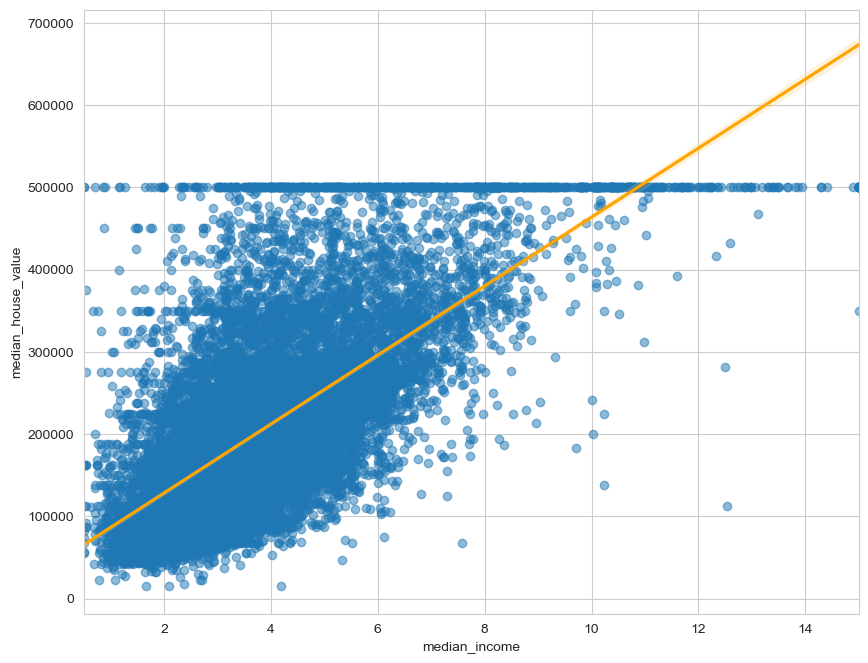

In [20]:
sns.regplot(x='median_income', y=target, data=train
            , scatter_kws={'alpha':0.5} , line_kws={"color": "orange"});
# plt.savefig('target-housing.png')
# plt.close();

median income is the most correlated feature for our target. There are lines at 500k where we see the cap but there are also lines between 450k and 350k, which needs to be address before we fit our model.

In [ ]:
## Using Seaborn
# sns.relplot(x='longitude', y='latitude', data=train, hue='median_house_value'
#             , palette=plt.get_cmap('jet')
#             , size=train['population']/100, sizes=(50,500), alpha=0.3 );
## Using MatplotLib
train.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=train['population']/100, label='population', c=target, 
             cmap=plt.get_cmap('jet'), colorbar=True);

Housing prices are very much related to the location and the population density. Clustering algorithm to detect main clusters and add new features that measure the proximity to the cluster centers.

# Data Cleaning
After doing an initial exploration, you must clean the dataset but start doing it only on **train**. As you clean it, you will build a pipeline of functions that you will use to clean the test set and any future dataset.

## Missing Data
Assess each numerical values for missing data and use the imputer to replace them with the median value.

In [ ]:
mis = train.isnull().sum()
mis = mis[mis>0]
pd.DataFrame({
    'count': mis,
    'proportion': mis / len(train)
}).sort_values(by='proportion', ascending=False).style.bar()

In [ ]:
from sklearn.impute import SimpleImputer
imp_median = SimpleImputer(strategy='median')
imp_median.fit(train[num])

pd.DataFrame(imp_median.transform(train[num]), columns=num).head() ## preview. can delete

Seems to be a lot of writing code for something simple. But here, we are getting used to *initiate, fit, transform* for sklearn, which will pay off in the long run once we build our automated pipeline.

## Categorical Encoding
For Categorical values, we need to encode them to zeros and ones.

In [ ]:
# train = train.join(pd.get_dummies(train['ocean_proximity']))

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
encoder.fit_transform(train[cat])

When encoding, it seems strange that we don't care of the columne names and just have the values zeros and ones. This must have a purpose later on. Better keep moving.

## Feature Engineering
There will be some features that would have a weak relationship with the target but are strongly correlated with other weak features. Exploring the combination of these features by combining them together may result into a stronger feature that we can use to improve our predictive capability of the target.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [ ]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) # initiate
housing_extra_attributes = attr_adder.transform(train.values) # transform

The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more lifely that you will find a great combination.

## Feature Scaling
Total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15.


### MinMaxScaler Normalization
Transforms the numeric data between 0 and 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # initiate
scaler.fit(train[num]) # fit
minmax = scaler.transform(train[num]) # transform
pd.DataFrame(minmax, columns=num).describe()

### Standardization
Uses standard deviation with mean as zero.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train[num])
pd.DataFrame(scaler.transform(train[num]), columns=num).describe()

You must only *fit* scalers to the **train** data. You must fit it to the whole data set or to the test set because this will cause overfitting when we do evaluation.

# Transformation Pipeline
Ok. This is where you get everything together. Do everything step by step.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class NewLabelBinarizer(LabelBinarizer):
    def fit(self, X, y=None):
        return super(NewLabelBinarizer, self).fit(X)
    def transform(self, X, y=None):
        return super(NewLabelBinarizer, self).transform(X)
    def fit_transform(self, X, y=None):
        return super(NewLabelBinarizer, self).fit(X).transform(X)

In [ ]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num))
    , ('imputer', SimpleImputer(strategy='median'))
    , ('attribs_adder', CombinedAttributesAdder())
    , ('std_scaler', StandardScaler())
])

In [ ]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat))
    , ('label_binarizer', NewLabelBinarizer())
])

In [ ]:
full_pipeline = FeatureUnion([
        ('num_pipeline', num_pipeline)
        , ('cat_pipeline', cat_pipeline)
])

In [ ]:
housing_prepared = full_pipeline.fit_transform(train)

# Machine Learning

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
housing_prepared = full_pipeline.transform(train) # does not have target
lin_reg = LinearRegression() # init
lin_reg.fit(housing_prepared, train[target]) # fit
lin_mse = mean_squared_error(train[target], lin_reg.predict(housing_prepared)) # predict evaluate
np.sqrt(lin_mse)

This is not ideal

## DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor() # init
tree_reg.fit(housing_prepared, train[target]) # fit
tree_mse = mean_squared_error(train[target], tree_reg.predict(housing_prepared))# predict evaluate
np.sqrt(tree_mse)

This is overfitting

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor() # init
forest_reg.fit(housing_prepared, train[target]) # fit
forest_mse = mean_squared_error(train[target], forest_reg.predict(housing_prepared))# predict evaluate
np.sqrt(forest_mse)

Better model to use.

## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, train[target],
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print(rmse_scores.mean())
print(rmse_scores.std())

In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, train[target],
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print(rmse_scores.mean())
print(rmse_scores.std())

In [ ]:
scores = cross_val_score(forest_reg, housing_prepared, train[target],
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print(rmse_scores.mean())
print(rmse_scores.std())

# Grid Search
- 3 n_estimators x 4 max_features = 12
- 2 n_estimators x 3 max_features = 6
- 5 folds x 18 combinations = 90 rounds of training

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, train[target])

In [ ]:
grid_search.best_params_

This shows the best parameter that made the best results

In [ ]:
grid_search.best_estimator_

You can see the best estimator to be used. Here we only placed 1.

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

You can see all the parameters and their corresponding scores here.

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

You can see which features are more stronger. Consider removing some weak ones.

# Evaluate in Test Set

In [ ]:
final_model = grid_search.best_estimator_
X_test = test.drop(target, axis=1)
Y_test = test[target]
X_test_prep = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prep)
final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse